In [76]:
#pandas 판다스 사용
import pandas as pd
meta = pd.read_csv('movies_metadata.csv')#csv파일 불러오기
meta = meta[ ['id', 'original_title', 'original_language', 'genres'] ]# 이 열만 뽑아내기
meta = meta.rename(columns={'id':'movieId',
 'original_title': 'title',
'original_language': 'language'})#열 이름 변경
meta = meta.loc[meta['language'] == 'en',:] #특정 열이 값이 en인 데이터만 뽑기

<ipython-input-76-7ee4ae458d15>:3: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  meta = pd.read_csv('movies_metadata.csv')#csv파일 불러오기


In [77]:
#테스트 데이터 정제
meta = pd.read_csv( 'movies_metadata.csv' )
meta = meta[ ['id', 'original_title', 'original_language', 'genres'] ]
meta = meta.rename(columns={'id':'movieId',
 'original_title': 'title',
'original_language': 'language'})
meta = meta.loc[meta['language'] == 'en',:]
meta.movieId = pd.to_numeric(meta.movieId)
def str_to_set(x):
 genre_set = set()
 for item in eval(x):
  genre_set.add(item['name'])
 return genre_set
meta.genres = meta.genres.apply(str_to_set)
keywords = pd.read_csv( 'keywords.csv' )
keywords.keywords = keywords.keywords.apply(str_to_set)
keywords = keywords.rename(columns={'id': 'movieId'})
keywords.movieId = pd.to_numeric(keywords.movieId)
meta = pd.merge(meta, keywords, on='movieId', how='inner')
dk = meta.loc[meta.title == 'The Dark Knight'].iloc[0]
dkr = meta.loc[meta.title == 'The Dark Knight Rises'].iloc[0]
pd.concat([dk, dkr], axis=1).T

ratings = pd.read_csv( 'ratings_small.csv' )
ratings.movieId = pd.to_numeric(ratings.movieId)
ratings = pd.merge(ratings, meta[['movieId', 'title']], on='movieId', how='inner')
matrix = ratings.pivot_table(index= 'userId', columns='title',
values='rating')


<ipython-input-77-459a0a786715>:2: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  meta = pd.read_csv( 'movies_metadata.csv' )


In [78]:
#jaccard similarity 자카르드 유사도
def jaccard_similarity(s1, s2):
 if len(s1|s2) == 0:
  return 0
 return len(s1&s2)/len(s1|s2)

 #test
jaccard_similarity(dk.genres|dk.keywords, dkr.genres|dkr.keywords)

0.37142857142857144

In [79]:
#pearson similarity 피어슨 유사도
import numpy as np
def pearson_similarity(u1, u2):
 u1_c = u1 - u1.mean()
 u2_c = u2 - u2.mean()
 denom = np.sqrt(np.sum(u1_c ** 2) * np.sum(u2_c ** 2))
 if denom != 0:
  return np.sum(u1_c * u2_c)/denom
 else:
  return 0

#test
dk_rating = matrix['The Dark Knight']
pk_rating = matrix['Prom Night']
pearson_similarity(dk_rating, pk_rating)

0.773565934694095

In [80]:
#cosine similarity 코사인 유사도, centered cosine similarity
import numpy as np
def cosine_similarity(a,b):#코사인 유사도 계산
    dot_product = np.dot(a, b)
    norm_a = np.linalg.norm(a)
    norm_b = np.linalg.norm(b)
    similarity = dot_product / (norm_a * norm_b)
    return similarity

def centering(array):#배열을 centering, 빈칸에 평균을 넣어주고 전부를 평균으로 빼줌
  a = array.copy()
  sum = 0
  cnt = 0
  tmp = np.array([],dtype='float32')
  for i in range(len(a)):
    if(a[i]!=0):
      tmp = np.append(tmp, a[i])

  m = tmp.mean()
  for i in range(len(a)):
    if a[i] == 0:
      a[i] =0
    else:
      a[i] -= m
  return a

#centered cosine similarity
def centered_cosine_similarity(arr,k):#점수 데이터(list[numpy]형태), 비교할 아이템의 인덱스번호
    #centering
  centered = []
  for i in range(len(arr)):
    centered.append(centering(arr[i]))
    #유사도 계산
  sim = []
  for i in range(len(arr)):
    sim.append(cosine_similarity(centered[k],centered[i]))
  return sim

#array를 float으로 선언
a=np.array([5,0,4,2,3],dtype='float32')
x=np.array([2,4,3,2,4],dtype='float32')

arr=[]
arr.append(x)
arr.append(a)
sim = centered_cosine_similarity(arr,0)
print(sim)

[1.0, -0.1118034]


In [81]:
#item-item collaborative filtering 아이템 콜라보 필터

#1.averaging 평균내기
a=np.array([5,3,4,2,3],dtype='float32')#x가 유사한 컨텐츠에 준 평점들
print(a.mean())


#2.가중치 평균

def sim_sort(sim):#유사도를 정렬
  sorted_sim = enumerate(sim)
  sorted_list = sorted(sorted_sim, key=lambda x: x[1])
  sorted_list.reverse()
  return sorted_list


def weight_averaging(arr,sorted_sim,N,user):#유사도를 기반으로 유사한 N개의 드라마를 선택해서 user의 평점 예측
  sim_sum=0
  SimRate_sum = 0
  for i in range(1,N+1):
    movie = sorted_sim[i][0]
    SimRate_sum += arr[movie][user]*sorted_sim[i][1]
    sim_sum += sorted_sim[i][1]
  print(SimRate_sum/sim_sum)


  #아이템 아이템 콜라보 필터링 다 합친거
  #평점 데이터 arr에 대해서 item에 대해 user가 내릴 평점을 유사한 N개의 아이템을 이용해 계산
def weight_collaborative_filtering(arr, item, N, user):
  sim = centered_cosine_similarity(arr,item)#centered 코사인 유사도를 이용한 유사도
  sorted_sim = sim_sort(sim)#정렬
  weight_averaging(arr,sorted_sim,N,user)


arr=[]#별점 데이터
arr.append(np.array([0,4,0,5,0,0,5,0,0,3,0,1],dtype='float32'))#없는 별점은 0
arr.append(np.array([3,1,2,0,0,4,0,0,4,5,0,0],dtype='float32'))
arr.append(np.array([0,5,3,4,0,3,0,2,1,0,4,2],dtype='float32'))
arr.append(np.array([0,2,0,0,4,0,0,5,0,4,2,0],dtype='float32'))
arr.append(np.array([5,2,0,0,0,0,2,4,3,4,0,0],dtype='float32'))
arr.append(np.array([0,4,0,0,2,0,0,3,0,3,0,1],dtype='float32'))

item = 0 #예측할 item
N=2 # 몇개의 유사한 item을 이용해서 예측할지
user = 7 #몇번째 user의 평점을 예측할지

sim = centered_cosine_similarity(arr,item)#유사도
sorted_sim = sim_sort(sim)#정렬된 유사도
weight_averaging(arr,sorted_sim,N,user)#가중치 평균 계산


weight_collaborative_filtering(arr, item, N, user)#한번에 아이템 콜라보 필터 계산


3.4
2.5864067624336537
2.5864067624336537


In [82]:
#global baseline estimate (GBE)
arr=[]#별점 데이터
arr.append(np.array([0,4,0,5,0,0,5,0,0,3,0,1],dtype='float32'))#없는 별점은 0
arr.append(np.array([3,1,2,0,0,4,0,0,4,5,0,0],dtype='float32'))
arr.append(np.array([0,5,3,4,0,3,0,2,1,0,4,2],dtype='float32'))
arr.append(np.array([0,2,0,0,4,0,0,5,0,4,2,0],dtype='float32'))
arr.append(np.array([5,2,0,0,0,0,2,4,3,4,0,0],dtype='float32'))
arr.append(np.array([0,4,0,0,2,0,0,3,0,3,0,1],dtype='float32'))
item = 0
user = 7
#gbe 계산
def GBE(arr,item,user):
  user_av = 0# 원하는 유저가 준 평균값
  item_av = 0# 원하는 아이템의 평균값
  all_av = 0#전체 평균
  user_cnt = 0# 유저가 준 평가의 수
  item_cnt = 0# 아이템이 받은 평가의 수
  all_cnt = 0# 전체 평가의 수
  for i in range(len(arr)):
    for j in range(len(arr[i])):
      if(arr[i][j]!=0):
        if(i==item):
          item_av+=arr[i][j]
          item_cnt+=1
        if(j==user):
          user_av+=arr[i][j]
          user_cnt+=1
        all_av+=arr[i][j]
        all_cnt+=1
  user_av /= user_cnt
  item_av /= item_cnt
  all_av /= all_cnt
  user_bias = user_av - all_av
  item_bias = item_av = all_av
  return(all_av+user_bias+item_bias)

#gbe + CF gbe+ collaborative filter GBE + 콜라보 필터
sim = centered_cosine_similarity(arr,item)#유사도
sorted_sim = sim_sort(sim)#정렬된 유사도
sim_sum=0
SimRate_sum = 0
N =1
for i in range(1,N+1):
  movie = sorted_sim[i][0]
  SimRate_sum += arr[item][user]*(sorted_sim[i][1]-(GBE(arr,item,i)))
  sim_sum += sorted_sim[i][1]
print(SimRate_sum/sim_sum+GBE(arr,item,user))


6.671428571428571


In [83]:
#데이터 가져오기
!wget https://files.grouplens.org/datasets/movielens/ml-100k.zip
!unzip ml-100k.zip

--2023-12-11 04:20:19--  https://files.grouplens.org/datasets/movielens/ml-100k.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4924029 (4.7M) [application/zip]
Saving to: ‘ml-100k.zip’

ml-100k.zip         100%[===================>]   4.70M  5.09MB/s    in 0.9s    

2023-12-11 04:20:20 (5.09 MB/s) - ‘ml-100k.zip’ saved [4924029/4924029]

Archive:  ml-100k.zip
   creating: ml-100k/
  inflating: ml-100k/allbut.pl       
  inflating: ml-100k/mku.sh          
  inflating: ml-100k/README          
  inflating: ml-100k/u.data          
  inflating: ml-100k/u.genre         
  inflating: ml-100k/u.info          
  inflating: ml-100k/u.item          
  inflating: ml-100k/u.occupation    
  inflating: ml-100k/u.user          
  inflating: ml-100k/u1.base         
  inflating: ml-100k/u1.test         
  inflating: ml-100k/u2.ba

In [84]:
import torch
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
train = pd.read_csv("ml-100k/ua.base",
 sep="\t", names=['user', 'item', 'rating', 'timestamp'])
test = pd.read_csv("ml-100k/ua.test",
 sep="\t", names=['user', 'item', 'rating', 'timestamp'])

items = torch.LongTensor(train['item'])
users = torch.LongTensor(train['user'])
ratings = torch.FloatTensor(train['rating'])
items_test = torch.LongTensor(test['item'])
users_test = torch.LongTensor(test['user'])
ratings_test = torch.FloatTensor(test['rating'])
print(test)
print(items_test)
print(users_test)
print(ratings_test)

      user  item  rating  timestamp
0        1    20       4  887431883
1        1    33       4  878542699
2        1    61       4  878542420
3        1   117       3  874965739
4        1   155       2  878542201
...    ...   ...     ...        ...
9425   943   232       4  888639867
9426   943   356       4  888639598
9427   943   570       1  888640125
9428   943   808       4  888639868
9429   943  1067       2  875501756

[9430 rows x 4 columns]
tensor([  20,   33,   61,  ...,  570,  808, 1067])
tensor([  1,   1,   1,  ..., 943, 943, 943])
tensor([4., 4., 4.,  ..., 1., 4., 2.])


epoch: 0, cost: 23.552452087402344, test_cost:21.15445899963379
epoch: 100, cost: 0.584902286529541, test_cost:1.561420202255249
epoch: 200, cost: 0.502240777015686, test_cost:1.9580262899398804
epoch: 300, cost: 0.47466540336608887, test_cost:2.2439239025115967
epoch: 400, cost: 0.46250155568122864, test_cost:2.532546043395996
epoch: 500, cost: 0.45616215467453003, test_cost:2.8411550521850586
epoch: 600, cost: 0.45198363065719604, test_cost:3.2022788524627686
epoch: 700, cost: 0.4490632116794586, test_cost:3.6121444702148438
epoch: 800, cost: 0.447090744972229, test_cost:4.009043216705322
epoch: 900, cost: 0.44572481513023376, test_cost:4.368853569030762
epoch: 1000, cost: 0.4447234272956848, test_cost:4.701723098754883


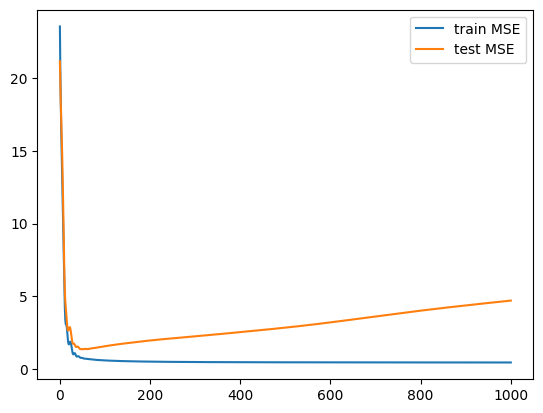

In [85]:
#latent factor model 기본
import torch
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
train = pd.read_csv("ml-100k/ua.base",
 sep="\t", names=['user', 'item', 'rating', 'timestamp'])
test = pd.read_csv("ml-100k/ua.test",
 sep="\t", names=['user', 'item', 'rating', 'timestamp'])

  #torch 텐서 데이터로 변환
items = torch.LongTensor(train['item'])
users = torch.LongTensor(train['user'])
ratings = torch.FloatTensor(train['rating'])
items_test = torch.LongTensor(test['item'])
users_test = torch.LongTensor(test['user'])
ratings_test = torch.FloatTensor(test['rating'])


rank = 10 # 사용자. 아이템의 차원
numItems = max(items) + 1 #아이템 수
numUsers = max(users) + 1 #유저 수

mean = ratings.mean()#점수의 평균

P = torch.randn(numItems, rank, requires_grad=True)#아이템 매트릭스
Q = torch.randn(numUsers, rank, requires_grad=True)#유저 매트릭스


mse = nn.MSELoss()
optim = torch.optim.Adam([P,Q], lr = 0.1)

x=[]
y=[]
y_test=[]


for epoch in range(1001):

  h = (P[items] * Q[users]).sum(dim=1)#가설함수
  cost = mse(h, ratings)#비용

  optim.zero_grad()
  cost.backward()
  optim.step()

  x.append(epoch)
  y.append(cost.item())
  with torch.no_grad():


    h_test = (P[items_test]*Q[users_test]).sum(dim=1)
    cost_test = mse(h_test, ratings_test)

    y_test.append(cost_test.item())

    if epoch % 100 == 0:
      print(f"epoch: {epoch}, cost: {cost.item()}, test_cost:{cost_test}")

plt.plot(x,y,label="train MSE")
plt.plot(x,y_test,label="test MSE")
plt.legend()
plt.show()

epoch: 0, cost: 23.62124252319336, test_cost:21.46318817138672
epoch: 100, cost: 13.685381889343262, test_cost:14.127147674560547
epoch: 200, cost: 13.685381889343262, test_cost:14.127147674560547
epoch: 300, cost: 13.685381889343262, test_cost:14.127147674560547
epoch: 400, cost: 13.685381889343262, test_cost:14.127147674560547
epoch: 500, cost: 13.685381889343262, test_cost:14.127147674560547
epoch: 600, cost: 13.685381889343262, test_cost:14.127147674560547
epoch: 700, cost: 13.685381889343262, test_cost:14.127147674560547
epoch: 800, cost: 13.685381889343262, test_cost:14.127147674560547
epoch: 900, cost: 13.685381889343262, test_cost:14.127147674560547
epoch: 1000, cost: 13.685381889343262, test_cost:14.127147674560547


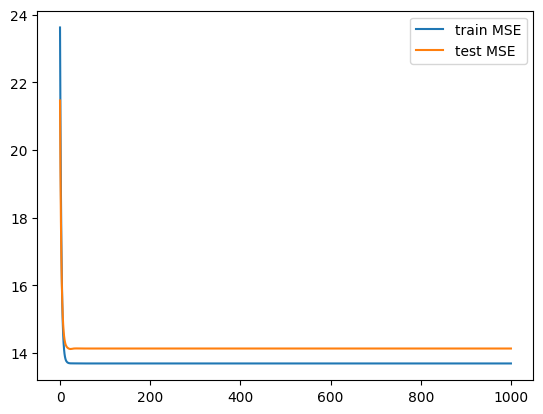

In [86]:
# regulazation을 통한 오버피팅 해결

rank = 10 # 사용자. 아이템의 차원
lambda1 = 0.1
lambda2 = 0.1
numItems = max(items) + 1 #아이템 수
numUsers = max(users) + 1 #유저 수

mean = ratings.mean()#점수의 평균

P = torch.randn(numItems, rank, requires_grad=True)#랜덤 아이템
Q = torch.randn(numUsers, rank, requires_grad=True)#랜덤 유저

mse = nn.MSELoss()
optim = torch.optim.Adam([P,Q], lr = 0.1)

x=[]
y=[]
y_test=[]

for epoch in range(1001):

  h = (P[items] * Q[users]).sum(dim=1)
  cost = mse(h, ratings)
  cost_reg = cost + lambda1 * (P ** 2).sum() + lambda2 * (Q ** 2).sum()

  optim.zero_grad()
  cost_reg.backward()
  optim.step()

  x.append(epoch)
  y.append(cost.item())

  with torch.no_grad():
    h_test = (P[items_test]*Q[users_test]).sum(dim=1)
    cost_test = mse(h_test, ratings_test)

    y_test.append(cost_test.item())

    if epoch % 100 == 0:
      print(f"epoch: {epoch}, cost: {cost.item()}, test_cost:{cost_test}")

plt.plot(x,y,label="train MSE")
plt.plot(x,y_test,label="test MSE")
plt.legend()
plt.show()


epoch: 0, cost: 13.420062065124512, test_cost:10.371530532836914
epoch: 100, cost: 0.49700266122817993, test_cost:1.134354591369629
epoch: 200, cost: 0.4569883346557617, test_cost:1.157268762588501
epoch: 300, cost: 0.4479169547557831, test_cost:1.1612577438354492
epoch: 400, cost: 0.44401946663856506, test_cost:1.1715117692947388
epoch: 500, cost: 0.4413752853870392, test_cost:1.1884340047836304
epoch: 600, cost: 0.4395505487918854, test_cost:1.199134111404419
epoch: 700, cost: 0.4385537803173065, test_cost:1.2008929252624512
epoch: 800, cost: 0.43805640935897827, test_cost:1.1980236768722534
epoch: 900, cost: 0.4377504885196686, test_cost:1.1891003847122192
epoch: 1000, cost: 0.43747231364250183, test_cost:1.1861509084701538


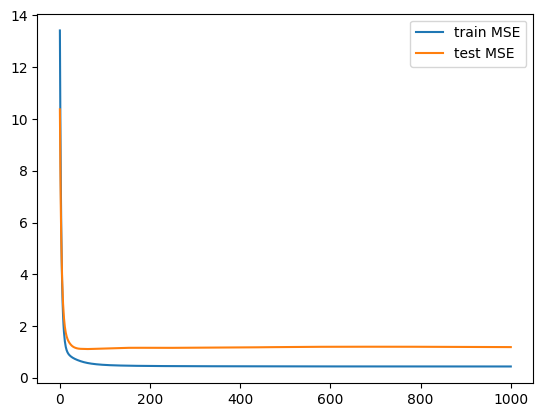

In [87]:
#bias 추가
rank = 10 # 사용자. 아이템의 차원
lambda1 = 0.1
lambda2 = 0.1
lambda3 = 0.1
lambda4 = 0.1

numItems = max(items) + 1
numUsers = max(users) + 1

mean = ratings.mean()

P = torch.randn(numItems, rank, requires_grad=True)
Q = torch.randn(numUsers, rank, requires_grad=True)
bias_user = torch.randn(numUsers, requires_grad=True)
bias_item = torch.randn(numItems, requires_grad=True)

mse = nn.MSELoss()
optim = torch.optim.Adam([P,Q,bias_user,bias_item], lr = 0.1)

x=[]
y=[]
y_test=[]

for epoch in range(1001):

  h = (P[items] * Q[users]).sum(dim=1) + mean + bias_item[items] + bias_user[users]
  cost = mse(h, ratings)
  cost_reg = cost + lambda1 * (P ** 2).mean() + lambda2 * (Q ** 2).mean() + \
  lambda3 *(bias_item**2).mean() + lambda4 *(bias_user**2).mean()

  optim.zero_grad()
  cost_reg.backward()
  optim.step()

  with torch.no_grad():
    x.append(epoch)
    y.append(cost.item())


    h_test = (P[items_test]*Q[users_test]).sum(dim=1) + mean \
              + bias_item[items_test] + bias_user[users_test]
    cost_test = mse(h_test, ratings_test)

    y_test.append(cost_test.item())

    if epoch % 100 == 0:
      print(f"epoch: {epoch}, cost: {cost.item()}, test_cost:{cost_test}")

plt.plot(x,y,label="train MSE")
plt.plot(x,y_test,label="test MSE")
plt.legend()
plt.show()


epoch: 0, cost: 19.62989616394043
epoch: 100, cost: 0.032141584903001785
epoch: 200, cost: 0.025565123185515404
epoch: 300, cost: 0.025175657123327255
epoch: 400, cost: 0.025145692750811577
epoch: 500, cost: 0.025140397250652313
epoch: 600, cost: 0.025139587000012398
epoch: 700, cost: 0.025139503180980682
epoch: 800, cost: 0.025139501318335533
epoch: 900, cost: 0.02513950504362583
epoch: 1000, cost: 0.025139497593045235


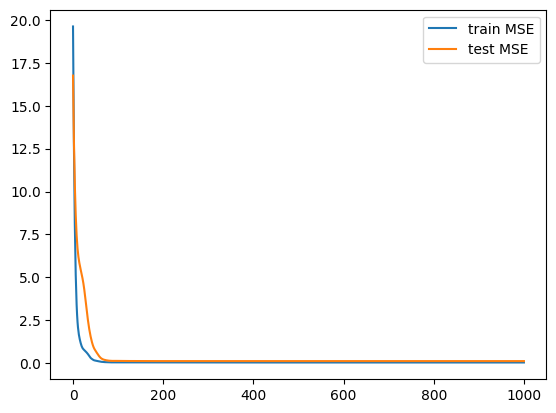

Predicted Rating for arr[0][1]: 3.9145572185516357
Actual Rating for arr[0][1]: 4.0


In [88]:
#latent factor model 평점에 적용####### ?? 있는 값은 잘 나오는데 예측값이 애매함
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# 별점 데이터
arr = [
    np.array([0, 4, 0, 5, 0, 0, 5, 0, 0, 3, 0, 1], dtype='float32'),
    np.array([3, 1, 2, 0, 0, 4, 0, 0, 4, 5, 0, 0], dtype='float32'),
    np.array([0, 5, 3, 4, 0, 3, 0, 2, 1, 0, 4, 2], dtype='float32'),
    np.array([0, 2, 0, 0, 4, 0, 0, 5, 0, 4, 2, 0], dtype='float32'),
    np.array([5, 2, 0, 0, 0, 0, 2, 4, 3, 4, 0, 0], dtype='float32'),
    np.array([0, 4, 0, 0, 2, 0, 0, 3, 0, 3, 0, 1], dtype='float32')
]

# 데이터를 tensor로
users = []
items = []
ratings = []
for i in range(len(arr)):
    for j in range(len(arr[i])):
        if arr[i][j] != 0:
            users.append(i)
            items.append(j)
            ratings.append(arr[i][j])

users = torch.LongTensor(users)
items = torch.LongTensor(items)
ratings = torch.FloatTensor(ratings)
users_test = users[-5:]
items_test = items[-5:]
ratings_test = ratings[-5:]

rank = 3
lambda1 = 0.01
lambda2 = 0.01
lambda3 = 0.1
lambda4 = 0.1

numItems = max(items) + 1
numUsers = max(users) + 1

P = torch.randn(numItems, rank, requires_grad=True)
Q = torch.randn(numUsers, rank, requires_grad=True)
bias_users = torch.randn(numUsers, requires_grad=True)
bias_items = torch.randn(numItems, requires_grad=True)


mse = nn.MSELoss()
optim = torch.optim.Adam([P, Q,bias_items,bias_users], lr=0.1)

x = []
y = []
y_test = []
for epoch in range(1001):
    h = (P[items] * Q[users]).sum(dim=1) +\
    bias_items[items] + bias_users[users]
    cost = mse(h, ratings)
    cost_reg = cost + lambda1 * torch.sum(P ** 2) + lambda2 * torch.sum(Q ** 2)\
    + lambda3*torch.sum(bias_items**2) + lambda4 * torch.sum(bias_users**2)


    optim.zero_grad()
    cost_reg.backward()
    optim.step()

    with torch.no_grad():
        x.append(epoch)
        y.append(cost.item())
        h_test = (P[items] * Q[users]).sum(dim=1)
        cost_test = mse(h_test, ratings)
        y_test.append(cost_test)
        if epoch % 100 == 0:
            print(f"epoch: {epoch}, cost: {cost.item()}")

plt.plot(x, y, label="train MSE")
plt.plot(x, y_test, label="test MSE")
plt.legend()
plt.show()

# Test with arr[0][1]
user_idx = 0
item_idx = 1

predicted_rating = (P[item_idx] @ Q[user_idx].T)

print(f"Predicted Rating for arr[0][1]: {predicted_rating}")
print(f"Actual Rating for arr[0][1]: {arr[user_idx][item_idx]}")



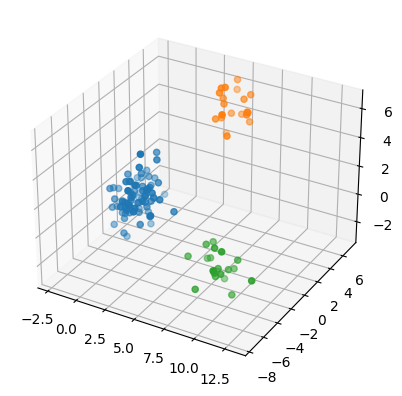

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
[[ 4.89598209  5.35071941  5.1923998 ]
 [-0.15302053 -0.05311164 -0.0533199 ]
 [10.12627799 -5.46769569  0.04269518]]


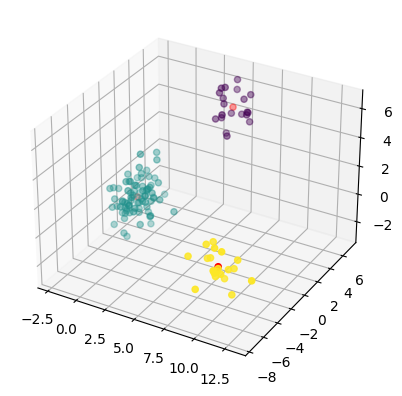

In [89]:
#clustering
#K-MEANS
import random
import numpy as np
import matplotlib.pyplot as plt

# 데이터 생성
dim = 3
points1 = np.random.randn(80, dim) #3차원 랜덤 포인트 80개
points2 = np.random.randn(20, dim) + np.array([5, 5, 5]) #중심점을 5,5,5 만큼 옮긴 새로운 클러스터
points3 = np.random.randn(20, dim) + np.array([10, -5,  0]) #중심점을 10,-5,0 만큼 옮긴 새로운 클러스터
points = np.concatenate( (points1, points2, points3) )#points 123을 다합친 어레이

#시각화
fig = plt.figure()
ax = fig.add_subplot(projection='3d')#3차원 만들기

#ax.scatter(points[:,0],points[:,1],points[:,2])
ax.scatter(points1[:,0],points1[:,1],points1[:,2])
ax.scatter(points2[:,0],points2[:,1],points2[:,2])
ax.scatter(points3[:,0],points3[:,1],points3[:,2])

plt.show()

def kmeans(k, points):#k개의 클러스터로 point들에 대해 계산

  prev_assignments = []


# 1. 임의로 k개의 점을 중심점으로 선택 (forgy),랜덤 centroids 추출
  centroids = points[np.random.choice(len(points),size = k,replace = False)]

  for epoch in range(10):

    #각 points가 어느 centroid랑 가장 가까운지게산 = 어느 클러스터에 속하는지
    assignments = []

    for p in points:
      min_dist = 9e9
      min_cid = -1
      for cid, c in enumerate(centroids):
        dist = ((c-p)**2).sum()#centroid와의 거리
        if dist<min_dist:
          min_dist = dist
          min_cid = cid
      assignments.append(min_cid)
    # assignments 기준으로 새로운 centroid 계산
    centroids = np.array([points[np.array(assignments)==cid].mean(axis =0) for cid, c in enumerate(centroids)])
    #변경되었는지 확인
    if prev_assignments == assignments:
      break

    prev_assignments = assignments
  return assignments, centroids

#kmeans 실행
assignments, centroids = kmeans(3,points)
print(assignments)
print(centroids)

#3차원으로 그리기
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(points[:,0],points[:,1],points[:,2], c = assignments)
ax.scatter(centroids[:,0],centroids[:,1],centroids[:,2], c = "red")
plt.show()

--2023-12-11 04:21:36--  https://pbs.twimg.com/media/EAmr-PAWsAEoiWR.jpg
Resolving pbs.twimg.com (pbs.twimg.com)... 192.229.233.50, 2606:2800:134:1a0d:1429:742:782:b6
Connecting to pbs.twimg.com (pbs.twimg.com)|192.229.233.50|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46271 (45K) [image/jpeg]
Saving to: ‘EAmr-PAWsAEoiWR.jpg’

EAmr-PAWsAEoiWR.jpg 100%[===================>]  45.19K  --.-KB/s    in 0.003s  

2023-12-11 04:21:36 (12.6 MB/s) - ‘EAmr-PAWsAEoiWR.jpg’ saved [46271/46271]



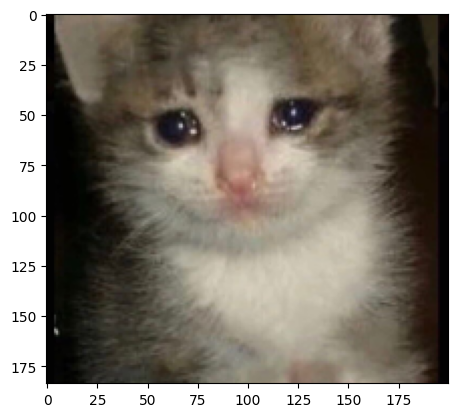

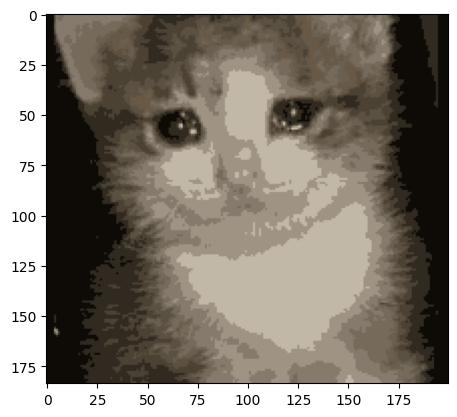

In [90]:
#k-means를 이용한 이미지처리
from PIL import Image
!wget https://pbs.twimg.com/media/EAmr-PAWsAEoiWR.jpg
im = Image.open("EAmr-PAWsAEoiWR.jpg")#이미지 열기
width = 200
height = im.height*200//im.width
im = im.resize((width,height))#비율을 유지하고 이미지 사이즈 조절
plt.imshow(im)
plt.show()

pixels = np.array(im).reshape((-1,3))#이미지 픽셀화
k=10
assignments, centroids = kmeans(k,pixels)#kmeans 실행

for a, i in zip(assignments, range(pixels.shape[0])):#kmeans결과를 이미지로 변환
 pixels[i] = centroids[a]
# 바뀐 그림 출력
im_remastered = Image.fromarray(pixels.reshape(im.height, im.width, 3))
plt.imshow(im_remastered)
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


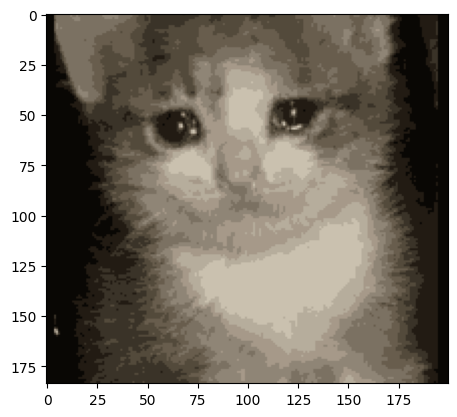

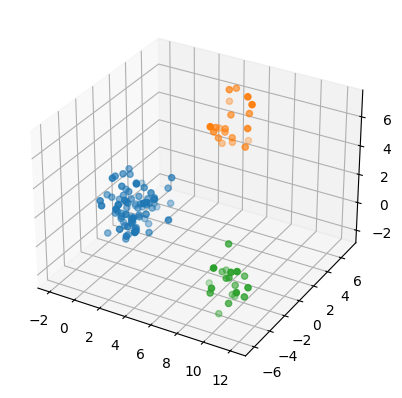

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


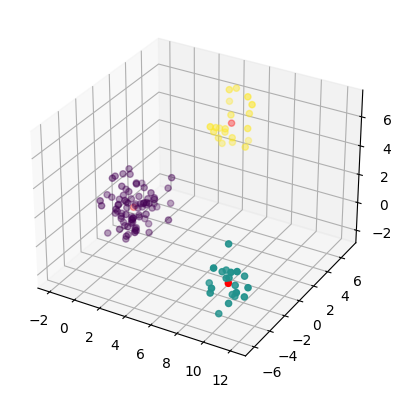

In [91]:
#sklearn을 통한 K-means
from sklearn.cluster import KMeans


#이미지 클러스터링
pixels = np.array(im).reshape((-1,3))#이미지 픽셀화

kmeans = KMeans(n_clusters =10)#k=10
kmeans.fit(pixels)#학습

for a, i in zip(kmeans.labels_, range(pixels.shape[0])):#kmeans결과를 이미지로 변환
 pixels[i] = kmeans.cluster_centers_[a]
# 바뀐 그림 출력

im_remastered = Image.fromarray(pixels.reshape(im.height, im.width, 3))
plt.imshow(im_remastered)
plt.show()


#3차원 데이터 클러스터링

dim = 3
points1 = np.random.randn(80, dim) #3차원 랜덤 포인트 80개
points2 = np.random.randn(20, dim) + np.array([5, 5, 5]) #중심점을 5,5,5 만큼 옮긴 새로운 클러스터
points3 = np.random.randn(20, dim) + np.array([10, -5,  0]) #중심점을 10,-5,0 만큼 옮긴 새로운 클러스터
points = np.concatenate( (points1, points2, points3) )#points 123을 다합친 어레이

#시각화
fig = plt.figure()
ax = fig.add_subplot(projection='3d')#3차원 만들기

#ax.scatter(points[:,0],points[:,1],points[:,2])
ax.scatter(points1[:,0],points1[:,1],points1[:,2])
ax.scatter(points2[:,0],points2[:,1],points2[:,2])
ax.scatter(points3[:,0],points3[:,1],points3[:,2])
plt.show()

kmeans = KMeans(n_clusters = 3)
kmeans.fit(points)

assignments = kmeans.labels_
centroids = kmeans.cluster_centers_

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(points[:,0],points[:,1],points[:,2], c = assignments)
ax.scatter(centroids[:,0],centroids[:,1],centroids[:,2], c = "red")
plt.show()

In [92]:
#iris 데이터 가져오기
!wget https://archive.ics.uci.edu/static/public/53/iris.zip
!unzip iris.zip

--2023-12-11 04:22:00--  https://archive.ics.uci.edu/static/public/53/iris.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘iris.zip’

iris.zip                [ <=>                ]   3.65K  --.-KB/s    in 0s      

2023-12-11 04:22:01 (495 MB/s) - ‘iris.zip’ saved [3738]

Archive:  iris.zip
  inflating: Index                   
  inflating: bezdekIris.data         
  inflating: iris.data               
  inflating: iris.names              


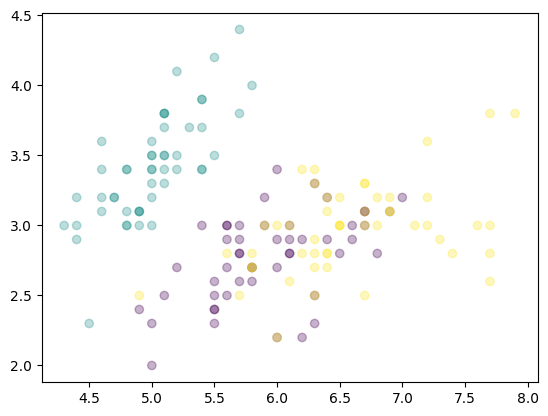

train accuracy: 0.9833333333333333
test accuracy: 0.9666666666666667


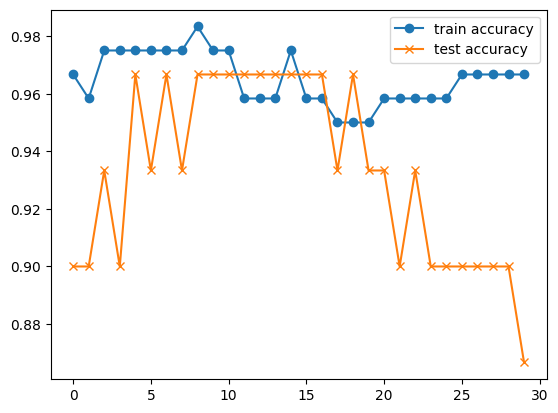

In [93]:
#knn

#데이터 분류
x = []
y = []

for line in open("iris.data", "r"):
  line = line.strip()#문자열 공백 지우기
  if line != '':
    tokens = line.split(',')# , 를 기준으로 분리
    x.append([float(t) for t in tokens[:4]])# 데이터를 넣기
    y.append(tokens[4])

y_labels = list(set(y))

y = [y_labels.index(i) for i in y]
import numpy as np
x = np.array(x)
y = np.array(y)
import matplotlib.pyplot as plt

plt.scatter(x[:,0], x[:,1], c=y, alpha=0.3)
plt.show()


#train data 분리
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=41)#test_size = 테스트 케이스의 비율

#knn 수행
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

knn = KNeighborsClassifier(n_neighbors=5)# n_neighbors = k
knn.fit(x_train,y_train)

y_train_pred = knn.predict(x_train)#train 데이터 결과값
y_test_pred = knn.predict(x_test)#test 결과값
#실제값과의 유사도
print("train accuracy:", accuracy_score(y_train_pred, y_train))
print("test accuracy:", accuracy_score(y_test_pred, y_test))

#최적의 k 찾기
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

scores = []
test_scores = []
k_values = range(1,31)

#반복수행해서 오차 기록
for k in k_values:
  knn = KNeighborsClassifier(n_neighbors=k)
  score = cross_val_score(knn, x_train, y_train, cv=10, scoring="accuracy")#cv = n-fold의 n
  scores.append(score.mean())
  knn.fit(x_train, y_train)
  y_pred = knn.predict(x_test)
  test_scores.append(accuracy_score(y_test, y_pred))


#그래프로 그리기
plt.plot(scores, "-o" , label="train accuracy")
plt.plot(test_scores,"-x", label="test accuracy")
plt.legend()
plt.show()


[[ 0.36138659 -0.08452251  0.85667061  0.3582892 ]
 [ 0.65658877  0.73016143 -0.17337266 -0.07548102]
 [-0.58202985  0.59791083  0.07623608  0.54583143]
 [-0.31548719  0.3197231   0.47983899 -0.75365743]]


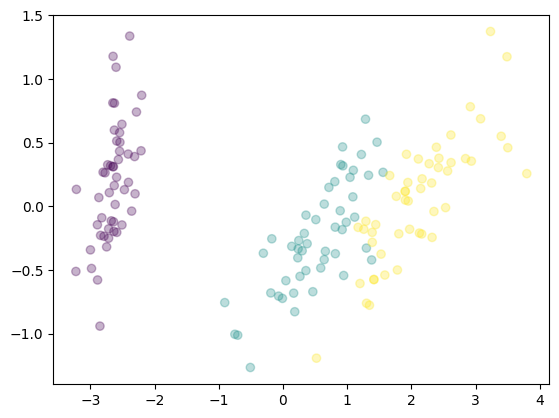

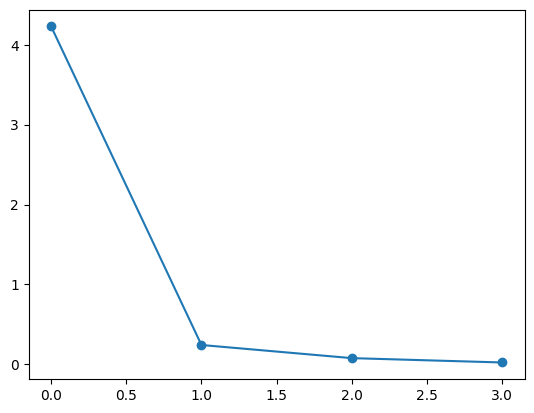

In [94]:
#PCA 주 성분 분석
from sklearn.datasets import load_iris
iris = load_iris()
iris['data']
iris['target']
iris['target_names']

#sklearn을 이용한 pca
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components = 4)#변환 후의 차원 수
Y = pca.fit_transform(iris['data'])

print(pca.components_)#주 성분

plt.scatter(Y[:,0], Y[:,1], c=iris['target'],alpha = 0.3)
plt.show()
plt.plot(pca.explained_variance_, "-o")#분산
plt.show()


L: [0.02367619 0.0776881  0.24105294 4.20005343]
Q: [[ 0.31548719  0.58202985  0.65658877 -0.36138659]
 [-0.3197231  -0.59791083  0.73016143  0.08452251]
 [-0.47983899 -0.07623608 -0.17337266 -0.85667061]
 [ 0.75365743 -0.54583143 -0.07548102 -0.3582892 ]]


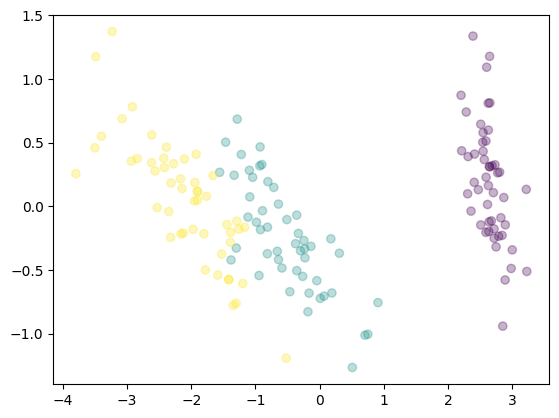

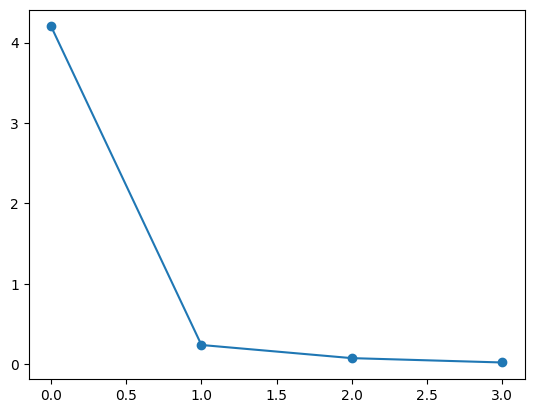

In [95]:
#eigen decomposition 을 통한 pca 아이젠 디컴포지션
#MQ = QA => MQQ(T) = QAQ(T) => M = QAQ(T) , M = 공분산 행렬,  A = 분산 <- ??
#orthgonal matrix = 들어있는 벡터들이 서로 수직이고 크기가 1인 행렬
from numpy import linalg
import matplotlib.pyplot as plt

X = iris.data
X = X - X.mean(axis=0)#축의 가운데로 데이터를 옮김

C = (X.T @ X) / X.shape[0] # covariance matrix 공분산 행렬

L, Q = linalg.eigh(C) # eigen decomposition, Q = 주 성분
print("L:", L)
print("Q:", Q)
Y = X @ Q
plt.scatter(Y[:,3], Y[:,2], c=iris.target, alpha = 0.3)
#==plt.scatter(X @ Q[:,3], X @ Q[:,2], c=iris.target)#데이터에 pc를 내적 하면 길이가 나옴
plt.show()
plt.plot(sorted(L, reverse=True), "-o")
plt.show()

[4.20005343 0.24105294 0.0776881  0.02367619]


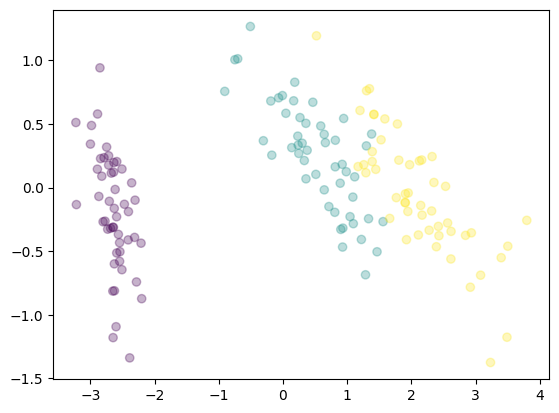

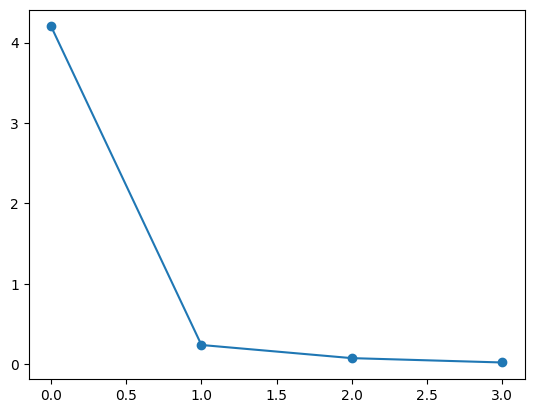

In [96]:
#SVD 를통한 PCA
from numpy import linalg

X = iris.data
X = X - X.mean(axis=0)# 중앙으로 옮기기

U, S, VT = linalg.svd(X)
Q = VT.T # 주 성분

print(S**2 / X.shape[0])
Y = X@Q
plt.scatter(Y[:,0], Y[:,1], c=iris.target, alpha = 0.3)
plt.show()
variances = (S ** 2) / X.shape[0]
plt.plot(variances, "-o")
plt.show()

L: [4.20005343 0.24105294 0.0776881  0.02367619]
Q: [[-0.36138659  0.65658877  0.58202985 -0.31548719]
 [ 0.08452251  0.73016144 -0.59791083  0.3197231 ]
 [-0.85667061 -0.17337266 -0.07623608  0.47983899]
 [-0.3582892  -0.07548102 -0.54583143 -0.75365743]]


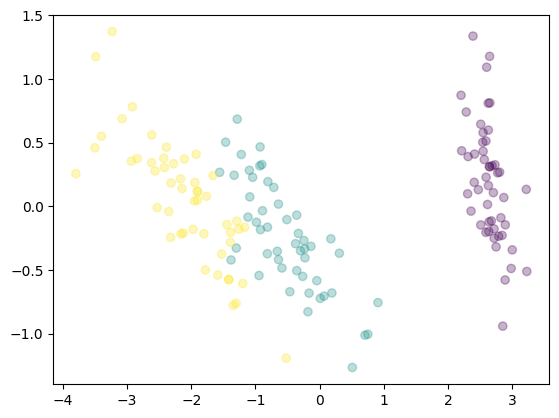

In [97]:
#power method PCA
from numpy import linalg
import matplotlib.pyplot as plt
import numpy as np
X = iris.data
X = X - X.mean(axis=0)
# covariance matrix
C = (X.T @ X) / X.shape[0] #공분산 행렬
M = C.copy()
L = []
Q = []

for dim in range(4):

  v = np.random.randn(4, 1)
  v = v / linalg.norm(v) # normalize

  for epoch in range(20):
    vp = M @ v
    lmd = linalg.norm(vp)
    v = vp / lmd

  M = M - lmd * (v @ v.T)
  L.append(lmd)
  Q.append(v)

L = np.array(L)
Q = np.hstack(Q)#col을 세로로 쌓아줌
print("L:", L)
print("Q:", Q)

Y = X @ Q
plt.scatter(Y[:,0], Y[:,1], c=iris.target, alpha = 0.3)
plt.show()

In [98]:
#주성분에 수직인 평면에 사영시킨 점
pc = np.array([2,1,2])#점
pc = pc / np.linalg.norm(pc)#pc의 법선벡터
dot = np.array([3,3,9])
projection = dot - np.dot(dot, pc) * pc #사영
projection

array([-3.,  0.,  3.])